In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv
/kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_661.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_240.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_295.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_158.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_35.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_145.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_476.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_449.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_104.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_419.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_136.par

# Detecting neutrinos in IceCube with machine learning.

This notebook is based on work done for Kaggle competition *IceCube - Neutrinos in Deep Ice*. The goal of the competition is to predict a neutrino particle’s direction. One was tasked with development of a model based on data from the "IceCube" detector, which observes the cosmos from deep within the South Pole ice.

This work could help scientists better understand exploding stars, gamma-ray bursts, and cataclysmic phenomena involving black holes, neutron stars and the fundamental properties of the neutrino itself.

## Context

One of the most abundant particles in the universe is the neutrino. While similar to an electron, the nearly massless and electrically neutral neutrinos have fundamental properties that make them difficult to detect. Yet, to gather enough information to probe the most violent astrophysical sources, scientists must estimate the direction of neutrino events. If algorithms could be made considerably faster and more accurate, it would allow for more neutrino events to be analyzed, possibly even in real-time and dramatically increase the chance to identify cosmic neutrino sources. Rapid detection could enable networks of telescopes worldwide to search for more transient phenomena.

Researchers have developed multiple approaches over the past ten years to reconstruct neutrino events. However, problems arise as existing solutions are far from perfect. They're either fast but inaccurate or more accurate at the price of huge computational costs.

The IceCube Neutrino Observatory is the first detector of its kind, encompassing a cubic kilometer of ice and designed to search for the nearly massless neutrinos. An international group of scientists is responsible for the scientific research that makes up the IceCube Collaboration.

By making the process faster and more precise, one can help improve the reconstruction of neutrinos. As a result, we could gain a clearer image of our universe.

## Dataset description 

**[train/test]_meta.parquet**

* batch_id (int): the ID of the batch the event was placed into.
* event_id (int): the event ID.
* [first/last]_pulse_index (int): index of the first/last row in the features dataframe belonging to this event.
* [azimuth/zenith] (float32): the [azimuth/zenith] angle in radians of the neutrino. A value between 0 and 2*pi for the azimuth and 0 and pi for zenith.
* The target columns. Not provided for the test set. The direction vector represented by zenith and azimuth points to where the neutrino came from.

 Other quantities regarding the event, such as the interaction point in x, y, z (vertex position), the neutrino energy, or the interaction type and kinematics are not included in the dataset.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

PATH = "/kaggle/input/icecube-neutrinos-in-deep-ice"

In [2]:
train_meta = pd.read_parquet(os.path.join(PATH, "train_meta.parquet"))
print(f"length: {len(train_meta)}")
display(train_meta.head())
display(train_meta.info())

length: 131953924


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953924 entries, 0 to 131953923
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   batch_id           int64  
 1   event_id           Int64  
 2   first_pulse_index  int64  
 3   last_pulse_index   int64  
 4   azimuth            float64
 5   zenith             float64
dtypes: Int64(1), float64(2), int64(3)
memory usage: 6.0 GB


None

#### Distribution of the first pulse index

Text(0.5, 0, 'time')

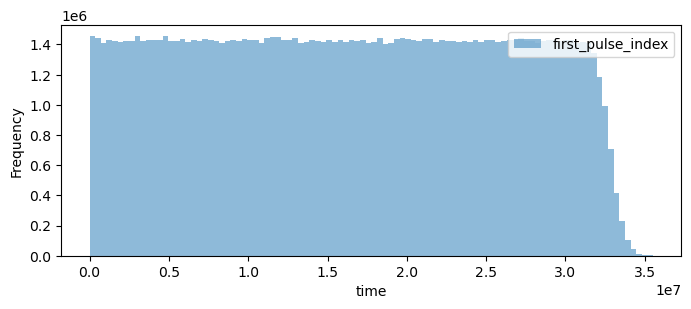

In [3]:
train_meta[["first_pulse_index"]].plot.hist(bins=100, alpha=0.5, figsize=(8, 3))
plt.xlabel('time')

#### Distribution of the last pulse index

Text(0.5, 0, 'time')

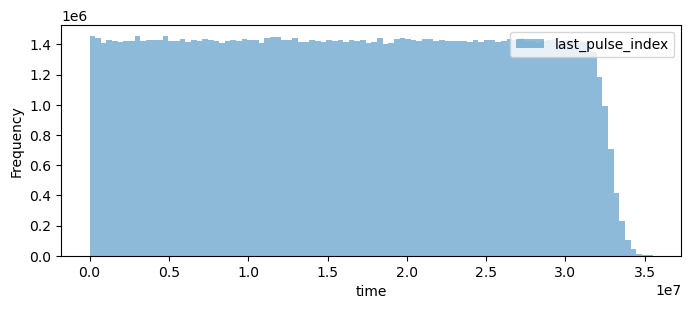

In [4]:
train_meta[["last_pulse_index"]].plot.hist(bins=100, alpha=0.5, figsize=(8, 3))
plt.xlabel('time')

#### Distribution of azimuth and zenith angles

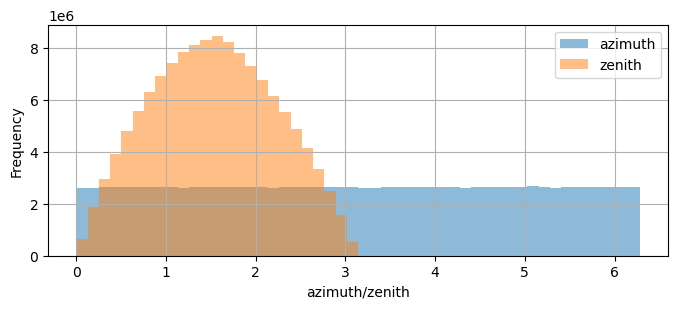

In [5]:
train_meta[["azimuth", "zenith"]].plot.hist(bins=50, alpha=0.5, figsize=(8, 3))
plt.xlabel('azimuth/zenith')
plt.grid()

**[train/test]/batch_[n].parquet** 

Each batch contains tens of thousands of events. Each event may contain thousands of pulses, each of which is the digitized output from a photomultiplier tube and occupies one row.

* event_id (int): the event ID. Saved as the index column in parquet.
* time (int): the time of the pulse in nanoseconds in the current event time window. The absolute time of a pulse has no relevance, and only the relative time with respect to other pulses within an event is of relevance.
* sensor_id (int): the ID of which of the 5160 IceCube photomultiplier sensors recorded this pulse.
* charge (float32): An estimate of the amount of light in the pulse, in units of photoelectrons (p.e.). A physical photon does not exactly result in a measurement of 1 p.e. but rather can take values spread around 1 p.e. As an example, a pulse with charge 2.7 p.e. could quite likely be the result of two or three photons hitting the photomultiplier tube around the same time. This data has float16 precision but is stored as float32 due to limitations of the version of pyarrow the data was prepared with.
* auxiliary (bool): If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If False, then this pulse was contributed to the trigger decision and the pulse was fully digitized.

In [6]:
train_batch_100 = pd.read_parquet(os.path.join(PATH, "train/batch_100.parquet"))
print(f"length: {len(train_batch_100)}")
print(f"events: {len(train_batch_100.index.unique())}")
train_batch_100.head()

length: 32998835
events: 200000


,sensor_id,time,charge,auxiliary
event_id,,,,
322165730,4443,5936,1.075,True
322165730,3860,6059,2.025,True
322165730,3860,6096,0.375,True
322165730,1610,6314,1.025,True
322165730,1150,6471,0.975,True


#### Display pulses per event in the batch.

In [7]:
pulses_in_batch = pd.DataFrame(train_batch_100.groupby('event_id').size(), columns=["n_pulses"])

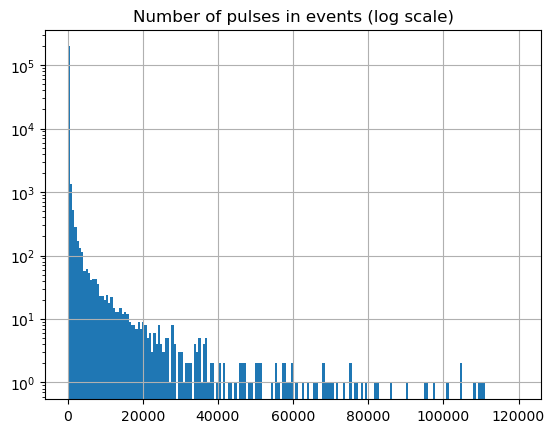

In [8]:
plt.hist(pulses_in_batch,200,(0,120000));
plt.yscale('log')
plt.title("Number of pulses in events (log scale)")
plt.grid()

#### Charge distribution (log scale)

Text(0, 0.5, 'charge')

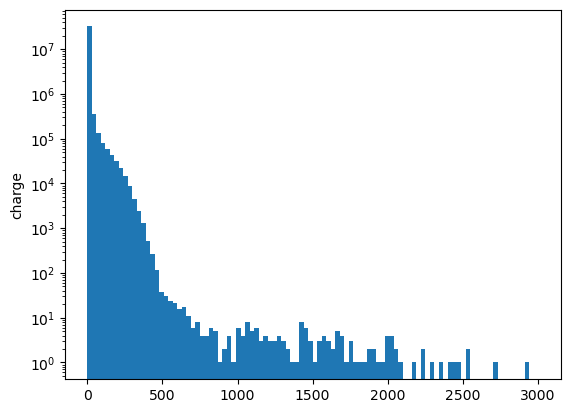

In [9]:
plt.hist(train_batch_100.charge, 100, (0, 3000));
plt.yscale("log")
plt.ylabel("charge")

#### Time intervals between consecutive pulses in the same sensor.

We explore the times between any two consecutive pulses in the same sensor to inform the architecture of our CONV1D time series model.

In [10]:
train_index = train_batch_100.index.to_numpy()
train_value = train_batch_100.to_numpy()
train_array = np.stack((train_index,train_value[:,0],train_value[:,1],train_value[:,2],train_value[:,3]),axis=1)
train_array[:5]

array([[322165730, 4443, 5936, 1.0750000476837158, True],
       [322165730, 3860, 6059, 2.0250000953674316, True],
       [322165730, 3860, 6096, 0.375, True],
       [322165730, 1610, 6314, 1.024999976158142, True],
       [322165730, 1150, 6471, 0.9750000238418579, True]], dtype=object)

In [11]:
# select sub-array of non-auxiliary events
good_array = train_array[train_array[:,4]==False]
# we no longer need the last two columns
good_times = good_array[:,:3].copy()
good_times[:5]

array([[322165730, 1768, 9878],
       [322165730, 1769, 9879],
       [322165730, 1770, 9889],
       [322165730, 1767, 9926],
       [322165730, 1771, 9965]], dtype=object)

For each event we would like to see which sensors were hit more than once. For these sensors we would like to determine times between consecutive hits. 
To accomplish our goal we want to sort events by id, within each event sort sensors by id, for each sensor sort times from earliest to latest. In this sorted array if a sensor within an event appears more than once we can record the time difference between consecutive hits. At the end we produce a histogram of the time differences between consecutive hits.

In [12]:
# we transform the good_times array from (n,3) shape into an (n,1) array by concatenating the digits of event id,
# sensor id and time
sorting_array = good_times[:,0]*1000000000 + good_times[:,1]*100000 + good_times[:,2]
# we sort sorting_array and record the indices of elements in this sorted array
sort = np.argsort(sorting_array)
# we use these indices to sort good_times array
good_times[sort][:]

array([[322165730, 1767, 9926],
       [322165730, 1768, 9878],
       [322165730, 1769, 9879],
       ...,
       [325430173, 2325, 14240],
       [325430173, 2327, 12890],
       [325430173, 2327, 14967]], dtype=object)

In [13]:
good_times_sorted = good_times[sort].copy()

In [14]:
event_diff = good_times_sorted[1:,0]-good_times_sorted[:-1,0]
sensor_diff = good_times_sorted[1:,1]-good_times_sorted[:-1,1]
time_diff = good_times_sorted[1:,2]-good_times_sorted[:-1,2]
de0ds0 = (event_diff==0)&(sensor_diff==0)

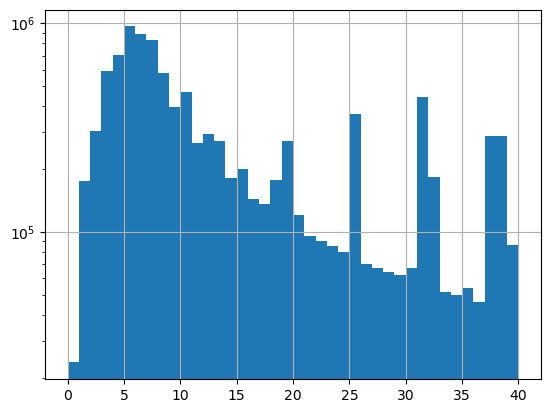

In [15]:
plt.hist(time_diff[de0ds0],40,(0,40));
plt.yscale('log')
plt.grid()

**sensor_geometry.csv** 

The x, y, and z positions for each of the 5160 IceCube sensors. The row index corresponds to the sensor_idx feature of pulses. The x, y, and z coordinates are in units of meters, with the origin at the center of the IceCube detector. The coordinate system is right-handed, and the z-axis points upwards when standing at the South Pole. 

In [16]:
sensor_geometry = pd.read_csv(os.path.join(PATH, "sensor_geometry.csv"))
print(f"length: {len(sensor_geometry)}")
sensor_geometry.head()

length: 5160


,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


Position of sensors inside the IceCube

In [17]:
import plotly.express as px

fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', opacity=0.6, color="sensor_id")
fig.update_traces(marker_size=2)
fig.update_layout(height=600, width=600)
fig.show()

## Our Approach

In the paper https://arxiv.org/pdf/2101.11589.pdf, a neutrino reconstruction method based on 3D convolutional neural networks (3D CNNs) is presented. There a neural network is set up as a multi-regression task. It is capable of achieving competitive reconstruction accuracy on neutrino properties, such as their incoming direction and energy. However, the authors mention that, since the measured pulses are summarized in nine input features per sensor in their model, this effectively removes the time dimension and results in a loss of
information. To further exploit the data representation as timed pulses series one might consider different network architectures such as 1D convolution in the time dimension or an RNN. This is the approch that we take.

## CONV1D NET

In [3]:
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling1D, Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow.math as tfm

from IPython.display import FileLink,FileLinks



### Data preparation

In [4]:
train_meta_df = train_meta
counter_df = pd.read_csv(os.path.join(PATH, "sensor_geometry.csv"))
train_batch_151_df = pd.read_parquet(os.path.join(PATH, "train/batch_151.parquet"))
train_batch_152_df = pd.read_parquet(os.path.join(PATH, "train/batch_152.parquet"))
train_batch_153_df = pd.read_parquet(os.path.join(PATH, "train/batch_153.parquet"))

**We will use two arbitrary selected batches as train data and one batch as validation data.**

In [5]:
train_batch = pd.concat([train_batch_151_df,train_batch_152_df])
train_meta = pd.concat([train_meta_df[train_meta_df.batch_id==151],train_meta_df[train_meta_df.batch_id==152]])
valid_batch = train_batch_153_df
valid_meta = train_meta_df[train_meta_df.batch_id==153]

We plan to construct a CONV1D net model. The input into CONV1D net should have a 
shape = (batch_size, number_of_timestamps, number_of features). Since most pulses happen within first 30000 nanoseconds, we will consider times up to 30000 nanoseconds(and truncate the pulses that occured after that). We further divide time into 6000 time steps, each of 5 nanoseconds duration. We will have 4 features: x,y,z coordinates of the sensor that recorded the pulse, and the charge of the recorded pulse. We, next, normalize x, y, z. We normalize the charge within the generator function as we use non-normalized values to compute the weighted averages of hits within one time step.

In [8]:
# find maximum absolute value of x,y,z coordinates
print(np.abs(counter_df.x).max(),
      np.abs(counter_df.y).max(),
      np.abs(counter_df.z).max())
counter_xyz_scale = np.max((
    np.abs(counter_df.x).max(),
    np.abs(counter_df.y).max(),
    np.abs(counter_df.z).max()))
counter_xyz_scale

1.0 0.9040720370595278 0.9101098252858406


1.0

In [9]:
# normalize the coordinates x, y, z of the sensors to be between -1 and 1
counter_df.x /= counter_xyz_scale
counter_df.y /= counter_xyz_scale
counter_df.z /= counter_xyz_scale
counter_df.head()

,sensor_id,x,y,z
0,0,-0.444402,-0.904072,0.860610
1,1,-0.444402,-0.904072,0.831081
2,2,-0.444402,-0.904072,0.801551
3,3,-0.444402,-0.904072,0.772021
4,4,-0.444402,-0.904072,0.742492


In [24]:
# find the maximum value of a charge a pulse carries
train_batch['charge'].max()

2944.22509765625

### Model construction

#### **Metrics and the loss function.**



The evaluation metric given in the competition was mean angular error between the true and predicted directions of a neutrino particle. We will use this metric as a metric to evaluate our model's performance as well as to define our loss function.

In [10]:

def mean_angular_error(y_true, y_pred):
#     if not (tfm.reduce_all(tfm.is_finite(y_true)) and
#             tfm.reduce_all(tfm.is_finite(y_pred))):
#         raise ValueError("All arguments must be finite")     
    
    # pre-compute all sine and cosine values
    sat = tfm.sin(y_true[:,0])
    cat = tfm.cos(y_true[:,0])
    szt = tfm.sin(y_true[:,1])
    czt = tfm.cos(y_true[:,1])
    sap = tfm.sin(y_pred[:,0])
    cap = tfm.cos(y_pred[:,0])
    szp = tfm.sin(y_pred[:,1])
    czp = tfm.cos(y_pred[:,1])
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = szt*szp*(cat*cap + sat*sap) + (czt*czp)
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  tf.clip_by_value(scalar_prod, -1, 1)
    # convert back to an angle (in radian)
    return tfm.reduce_mean(tfm.abs(tfm.acos(scalar_prod))) 

We experimented with a different loss function suggested by a domain expert, but this loss function did not lead to better results.

In [9]:
def ms_angular_error(y_true, y_pred):
    weighted_square_error = (y_true[:,1] - y_pred[:,1])**2 + tfm.sin(y_pred[:,1])**2 * (y_true[:,0] - y_pred[:,0])**2
    return tfm.reduce_mean(weighted_square_error)

#### **The generator function**

In [12]:
def get_IceCube_data_generator(meta_df,batch_event_df,counter_df,batch_size=32):
    """
    Generator to give time-series counter data in batches
    
    Inputs:
        meta_df          The metadata df selected for the current IceCube batch
        batch_event_df   The data from a given IceCube batch (must match the meta_df)
        counter_df       DataFrame with counter xyz values
        batch_size       Number of events in a minibatch
        
    Yields:
        tuple of (time_series_minibatch      shape[batch_size,T,4],
                  direction_vector_minibatch shape[batch_size,2])
    """
    #T = 30000
    T = 6000
    D = 4
    #time_step = 1
    time_step = 5
    log_charge_scale = 10
    num_batches = meta_df.shape[0]//batch_size + 1
    while True:
        for i in range(num_batches):
            X_minibatch = np.zeros((batch_size,T,D),dtype=float)
            Y_minibatch = np.zeros((batch_size,2),dtype=float)
            for j in range(batch_size):
                # get index of the event in meta
                event_idx_meta = i*batch_size + j
                if event_idx_meta >= meta_df.shape[0]:
                    break
                # use index to get event id from meta
                event_id = meta_df.iloc[event_idx_meta,1]
                # use event id to get the entire event
                event = batch_event_df.loc[event_id]
                # we take only non-auxiliary pulses, since we consider
                # auxiliary pulses to be noise
                event_good = event.loc[event['auxiliary']==False]
                start_t = time_step*(event_good['time'].min()//time_step)
                # consider times of pulses relative to the time of the first pulse
                rel_time_idx = ((event_good['time'].values-start_t)//time_step).astype(int)
                # truncate pulses after 30000 nanoseconds
                rel_time_idx[rel_time_idx>T-1] = T-1
                
                c = event_good['charge'].values
                # make an array of sensor positions synchronized with event_good sensors
                r = counter_df.values[event_good.sensor_id,1:4]
                # multiply each coordinate of the sensor position by the charge of the recorded pulse
                r *= c.reshape(-1,1)
                
                # k is the index of rel_time_idx
                for k in range(len(rel_time_idx)):
                    # for each time bin we compute the sum of coordinates weighted by charge of sensors that recorded
                    # pulses in this time bin and the total charge recorded in this time bin
                    for ir in range(3):
                        X_minibatch[j,rel_time_idx[k],ir] += r[k,ir]
                    X_minibatch[j,rel_time_idx[k],3] += c[k]
                
                # select the entries of X_minibatch with non-zero charge
                gt0 = X_minibatch[j,:,3] > 0
                # divide the weighted sum of coordinates of sensors in a time bin by the total charge accumulated
                # in this time bin
                # x_weighted = (x_1 * c_1 + x_2 * c_2 + ... x_l * c_l) / (c_1 + c_2 + ... + c_l)
                X_minibatch[j,gt0,:3] /= X_minibatch[j,gt0,3].reshape(-1,1)
                # we now normalize the charge using the formula: charge = ln(charge + 1) /10
                X_minibatch[j,gt0,3] = np.log(1.+ X_minibatch[j,gt0,3])/log_charge_scale
                
                Y_minibatch[j,0] = meta_df.iloc[event_idx_meta,4]
                Y_minibatch[j,1] = meta_df.iloc[event_idx_meta,5]
            yield X_minibatch,Y_minibatch
                                

### **Building our models.**

#### 2 Conv layers

In [35]:
#T = 30000
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,6,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(16,10,strides=2,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [36]:
model = Model(i,x)
model.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [37]:

r = model.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1543s 247ms/step - loss: 1.4955 - mean_angular_error: 1.4955 - val_loss: 1.4726 - val_mean_angular_error: 1.4726
Epoch 2/8
6251/6251 [==============================] - 1553s 248ms/step - loss: 1.4754 - mean_angular_error: 1.4754 - val_loss: 1.4680 - val_mean_angular_error: 1.4680
Epoch 3/8
6251/6251 [==============================] - 1547s 247ms/step - loss: 1.4703 - mean_angular_error: 1.4703 - val_loss: 1.4583 - val_mean_angular_error: 1.4583
Epoch 4/8
6251/6251 [==============================] - 1554s 249ms/step - loss: 1.4647 - mean_angular_error: 1.4647 - val_loss: 1.4466 - val_mean_angular_error: 1.4466
Epoch 5/8
6251/6251 [==============================] - 1506s 241ms/step - loss: 1.4583 - mean_angular_error: 1.4583 - val_loss: 1.4424 - val_mean_angular_error: 1.4424
Epoch 6/8
6251/6251 [==============================] - 1544s 247ms/step - loss: 1.4530 - mean_angular_error: 1.4530 - val_loss: 1.4352 - val_mean_angular_error:

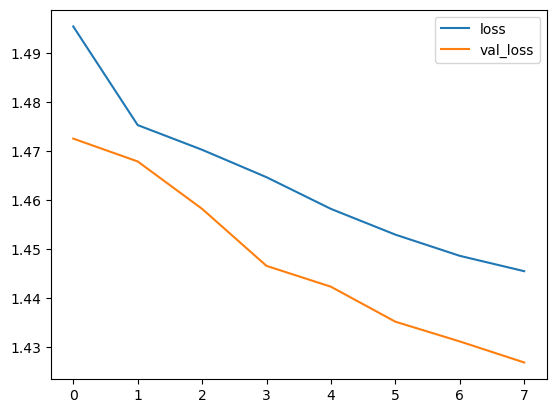

In [38]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [39]:
from IPython.display import FileLink,FileLinks

In [40]:
# save the model
model.save('cnn1d-fit-2.hd5')
os.chdir(r'/kaggle/working')
!tar czf cnn1d-fit-2.hd5.tgz cnn1d-fit-2.hd5/
FileLink('cnn1d-fit-2.hd5.tgz')

/kaggle/working/cnn1d-fit-2.hd5.tgz

In [14]:
import shutil

In [43]:
os.listdir('/kaggle/input/cnn1d-fit-2')

['cnn1d-fit-2.hd5.tgz']

In [11]:
shutil.copy('/kaggle/input/cnn1d-fit-2/cnn1d-fit-2.hd5.tgz', '/kaggle/working/')

'/kaggle/working/cnn1d-fit-2.hd5.tgz'

In [46]:
os.listdir('/kaggle/working/')

['cnn1d-fit-2.hd5.tgz',
 '__notebook_source__.ipynb',
 'cnn1d-fit-2.hd5',
 '.virtual_documents']

In [12]:
!tar xzf cnn1d-fit-2.hd5.tgz

In [13]:
# load the saved model
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/cnn1d-fit-2.hd5',
                  custom_objects={"mean_angular_error": mean_angular_error})
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6000, 4)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 6000, 16)          400       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1500, 16)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 750, 16)           2576      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 187, 16)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2992)              0   

Next we look at our predictions on the first mini-batch of the validation set. We plot our best prediction and our worst prediction in an attempt to understand when our model does well and how we can improve it.

In [19]:
dg = get_IceCube_data_generator(valid_meta,valid_batch,counter_df)
X,y = dg.__next__()
y_p = model(X)

In [20]:
# a function to draw an event with the true direction and the predicted direction
def draw_event_with_predictions(event_id,batch_df,meta_df,counter_df,iy,y,y_p):
    """
    Draw an event using plotly. 
    
    inputs:
        event_id    ID number of event used in batch_df and meta_df
        batch_df    Event dataframe containing counter hits and timings
        meta_df     Event metadata dataframe containing true angles
        counter_df  Counter location dataframe
        iy          Index of this event in the model outputs
        y           True values (also in meta_df but transformed)
        y_p         Predicted values
    """

    # Get dataframe with just the good counters in this event
    event_all  = batch_df.loc[event_id]
    event_good = event_all.loc[event_all.auxiliary==False]
    event = event_good.copy()
    
        # Add locations to the event dataframe
    event['x'] = counter_df.loc[event.sensor_id]['x'].to_numpy()
    event['y'] = counter_df.loc[event.sensor_id]['y'].to_numpy()
    event['z'] = counter_df.loc[event.sensor_id]['z'].to_numpy()
    
    # Get entry in meta_df
    meta = meta_df.loc[meta_df.event_id==event_id]
    
    # Start a figure
    fig = go.Figure()
    
    # Add all counters (almost transparent)
    fig.add_trace(go.Scatter3d(x=counter_df.x.to_numpy(),
                               y=counter_df.y.to_numpy(),
                               z=counter_df.z.to_numpy(),
                               mode='markers',
                               marker=dict(
                                   size=1,
                                   color='grey',
                                   opacity=0.3
                               ),
                              name='All counters'))
    
    # Add good counters from this event
    fig.add_trace(go.Scatter3d(x=event.x.to_numpy(),
                               y=event.y.to_numpy(),
                               z=event.z.to_numpy(),
                               mode='markers',
                               marker=dict(
                                   size=10.*event.charge.to_numpy(),
                                   color=event.time.to_numpy(),
                                   colorscale='Viridis',
                                   opacity=0.95
                               ),
                              name='Counters with Time'))
    
    # Add lines for true and predicted direction
    xm = event.x.to_numpy().sum()/event.x.to_numpy().shape[0]
    ym = event.y.to_numpy().sum()/event.y.to_numpy().shape[0]
    zm = event.z.to_numpy().sum()/event.z.to_numpy().shape[0]
    th = y[iy,0]
    ph = y[iy,1]
    x0 = -1*np.sin(th)*np.cos(ph)+xm
    y0 = -1*np.sin(th)*np.sin(ph)+ym
    z0 = -1*np.cos(th)            +zm
    x1 =  np.sin(th)*np.cos(ph)+xm
    y1 =  np.sin(th)*np.sin(ph)+ym
    z1 =  np.cos(th)            +zm
    
    fig.add_trace(go.Scatter3d(x=(x0,x1),
                               y=(y0,y1),
                               z=(z0,z1),
                               marker=dict(
                                   size=1,
                                   color='red'
                               ),
                               line=dict(
                                   color='red',
                                   width=5
                               ),
                              name='True Direction'))
    
    th = y_p[iy,0]
    ph = y_p[iy,1]
    x0 = -1*np.sin(th)*np.cos(ph)+xm
    y0 = -1*np.sin(th)*np.sin(ph)+ym
    z0 = -1*np.cos(th)            +zm
    x1 =  np.sin(th)*np.cos(ph)+xm
    y1 =  np.sin(th)*np.sin(ph)+ym
    z1 =  np.cos(th)            +zm
    fig.add_trace(go.Scatter3d(x=(x0,x1),
                               y=(y0,y1),
                               z=(z0,z1),
                               marker=dict(
                                   size=1,
                                   color='blue'
                               ),
                               line=dict(
                                   color='blue',
                                   width=5
                               ),
                              name='Predicted Direction'))
    
    fig.show()

In [21]:
# look at the first mini-batch of validation meta
valid_meta.head(32)

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
30400000,153,494683084,0,42,3.594802,1.337768
30400001,153,494683109,43,95,3.026425,0.784238
30400002,153,494683118,96,146,0.113842,2.044199
30400003,153,494683131,147,216,2.253524,2.714524
30400004,153,494683163,217,269,4.625610,2.219761
30400005,153,494683173,270,364,4.856068,1.783187
30400006,153,494683180,365,399,4.084661,1.532734
30400007,153,494683269,400,480,0.630505,1.839187
30400008,153,494683326,481,525,1.625260,0.760789
30400009,153,494683438,526,648,5.700527,2.331018


In [22]:
events = valid_meta.loc[30400000:30400032].event_id.to_numpy()

In [22]:
# angular_error function for one event
def angular_error(y_true, y_pred):    
    
    # pre-compute all sine and cosine values
    sat = np.sin(y_true[0])
    cat = np.cos(y_true[0])
    szt = np.sin(y_true[1])
    czt = np.cos(y_true[1])
    sap = np.sin(y_pred[0])
    cap = np.cos(y_pred[0])
    szp = np.sin(y_pred[1])
    czp = np.cos(y_pred[1])
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = szt*szp*(cat*cap + sat*sap) + (czt*czp)
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  tf.clip_by_value(scalar_prod, -1, 1)
    # convert back to an angle (in radian)
    return tfm.acos(scalar_prod) 

In [24]:
# compute angular_error on each event in the first mini-batch
errors = [angular_error(y[j], y_p[j]) for j in range(32)]
errors

[<tf.Tensor: shape=(), dtype=float64, numpy=1.30517832706213>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4765809790777248>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.8276850384881766>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.680573424357531>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.2021288684637708>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.0118112642536428>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.57547709058855>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.0518555395148383>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.334660983666196>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.159869063076638>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.445627178132874>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.033919470500993>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.2410165462437988>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.761557140401737>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.1868573789948345>,
 <tf.Tensor: shape=(), dtype=float6

In [40]:
# find the best and worst events
print(min(errors), max(errors))

tf.Tensor(0.30234638523554047, shape=(), dtype=float64) tf.Tensor(2.680573424357531, shape=(), dtype=float64)


In [25]:
# find the indices of the best and worst events in the mini-batch
print(errors.index(min(errors)), errors.index(max(errors)))

20 3


In [26]:
# make plots of the worst, second worst, best and second best events
from plotly.subplots import make_subplots

In [27]:
for j in [3, 4, 20, 1]:
    draw_event_with_predictions(events[j],valid_batch,valid_meta,counter_df,j,y,y_p)

We look at the cumulative charge and charge distribution in good and bad events

In [28]:
bad_event = valid_batch.loc[494683118]
bad_event_non_aux = bad_event.loc[bad_event['auxiliary']==False]
bad_event_non_aux

,sensor_id,time,charge,auxiliary
event_id,,,,
494683118,1021,9108,0.675,False
494683118,1020,9202,1.375,False
494683118,1021,9394,0.925,False
494683118,1021,9436,0.525,False
494683118,1021,9692,0.975,False
494683118,187,9873,1.725,False
494683118,188,9881,0.525,False
494683118,186,9926,0.725,False
494683118,188,9928,0.975,False


In [29]:
bad_event_non_aux.charge.sum()

10.075000047683716

Text(0, 0.5, 'charge')

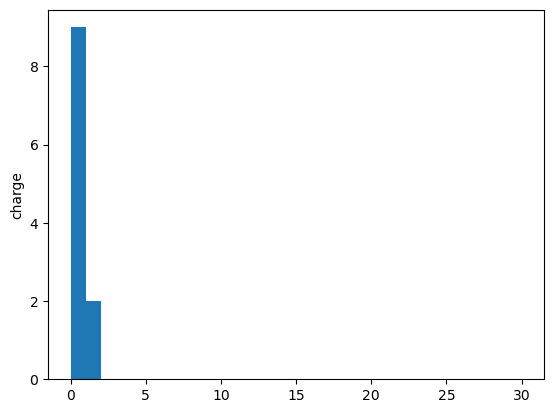

In [30]:
plt.hist(bad_event_non_aux.charge, 30, (0, 30));
plt.ylabel("charge")

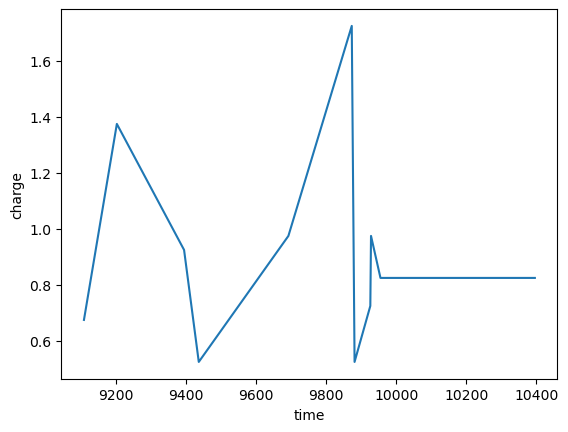

In [31]:
plt.plot(bad_event_non_aux.time, bad_event_non_aux.charge);
plt.xlabel('time')
plt.ylabel('charge');

In [32]:
bad_event_2 = valid_batch.loc[494683163]
bad_event_2_non_aux = bad_event_2.loc[bad_event_2['auxiliary']==False]
bad_event_2_non_aux

,sensor_id,time,charge,auxiliary
event_id,,,,
494683163,2782,9091,0.825,False
494683163,2781,9162,1.175,False
494683163,2781,9536,1.225,False
494683163,2781,9724,1.425,False
494683163,3056,9874,0.925,False
494683163,3053,9898,1.025,False
494683163,2517,9922,0.225,False
494683163,3054,10008,0.225,False
494683163,3054,10016,0.625,False


In [33]:
bad_event_2_non_aux.charge.sum()

8.62499988079071

Text(0, 0.5, 'charge')

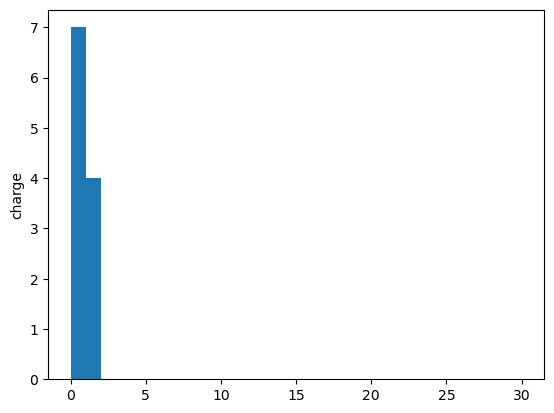

In [34]:
plt.hist(bad_event_2_non_aux.charge, 30, (0, 30));
plt.ylabel("charge")

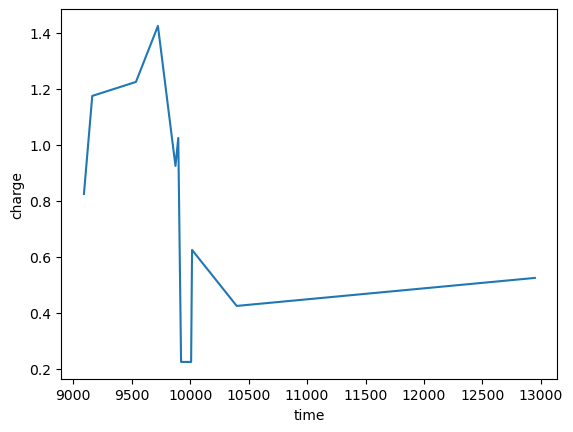

In [35]:
plt.plot(bad_event_2_non_aux.time, bad_event_2_non_aux.charge);
plt.xlabel('time')
plt.ylabel('charge');

In [36]:
good_event = valid_batch.loc[494683571]
good_event_non_aux = good_event.loc[good_event['auxiliary']==False]
good_event_non_aux

,sensor_id,time,charge,auxiliary
event_id,,,,
494683571,2379,9884,2.075,False
494683571,2379,9889,1.275,False
494683571,2380,9900,0.675,False
494683571,2380,9904,1.525,False
494683571,2379,9905,0.975,False
...,...,...,...,...
494683571,2998,11686,1.225,False
494683571,2377,11904,0.525,False
494683571,2380,16607,0.525,False


In [37]:
good_event_non_aux.charge.sum()

169.1000004261732

Text(0, 0.5, 'charge')

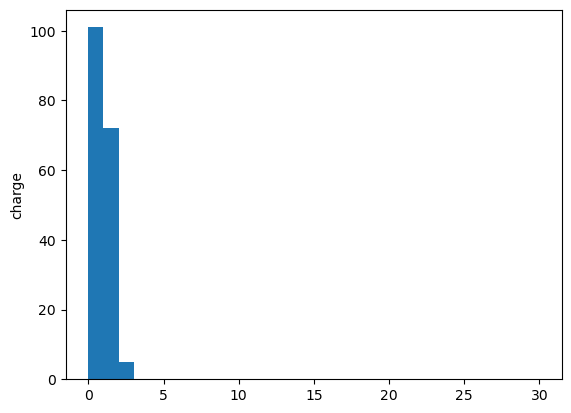

In [38]:
plt.hist(good_event_non_aux.charge, 30, (0, 30));
plt.ylabel("charge")

Text(0, 0.5, 'charge')

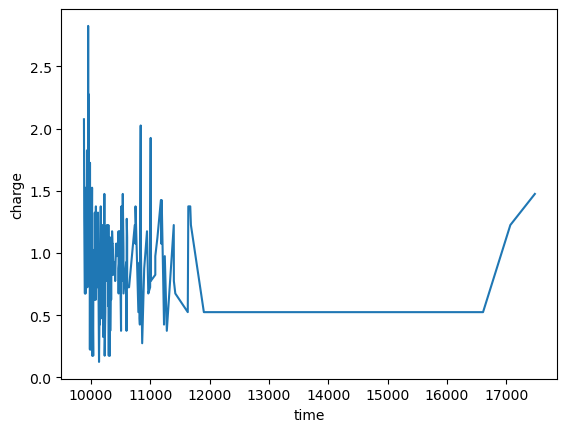

In [39]:
plt.plot(good_event_non_aux.time, good_event_non_aux.charge);
plt.xlabel('time')
plt.ylabel('charge')

In [40]:
good_event_2 = valid_batch.loc[494683109]
good_event_2_non_aux = good_event_2.loc[good_event_2['auxiliary']==False]
good_event_2_non_aux

,sensor_id,time,charge,auxiliary
event_id,,,,
494683109,225,9871,0.775,False
494683109,165,9913,0.875,False
494683109,228,9994,1.025,False
494683109,167,9999,0.425,False
494683109,168,10060,0.725,False
494683109,223,10086,0.725,False
494683109,227,10568,0.825,False
494683109,230,10593,0.775,False
494683109,231,10736,1.375,False


In [41]:
good_event_2_non_aux.charge.sum()

13.89999994635582

Text(0, 0.5, 'charge')

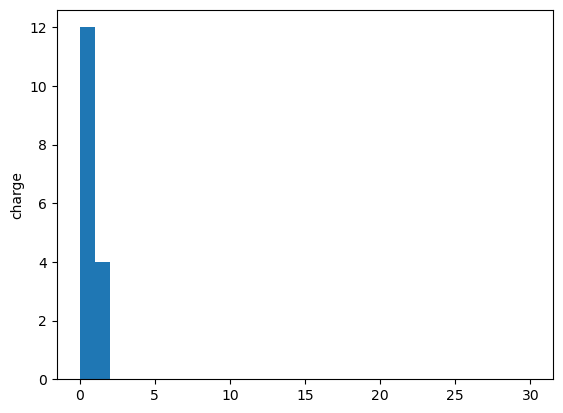

In [42]:
plt.hist(good_event_2_non_aux.charge, 30, (0, 30));
plt.ylabel("charge")

Text(0, 0.5, 'charge')

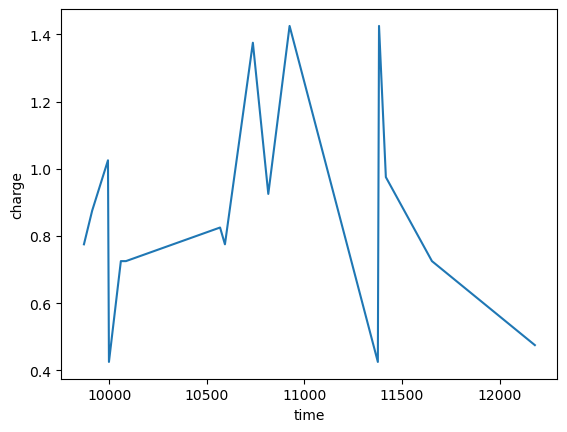

In [43]:
plt.plot(good_event_2_non_aux.time, good_event_2_non_aux.charge);
plt.xlabel('time')
plt.ylabel('charge')

In [44]:
good_event_3 = valid_batch.loc[494683692]
good_event_3_non_aux = good_event_3.loc[good_event_3['auxiliary']==False]
good_event_3_non_aux

,sensor_id,time,charge,auxiliary
event_id,,,,
494683692,2976,9874,3.875,False
494683692,2976,9875,16.525,False
494683692,2976,9879,18.725,False
494683692,2976,9885,5.425,False
494683692,2976,9891,4.125,False
494683692,2976,9915,0.475,False
494683692,2976,9923,1.625,False
494683692,2976,9934,1.925,False
494683692,2977,9943,1.175,False


In [45]:
good_event_3_non_aux.charge.sum()

71.87500017881393

Text(0, 0.5, 'charge')

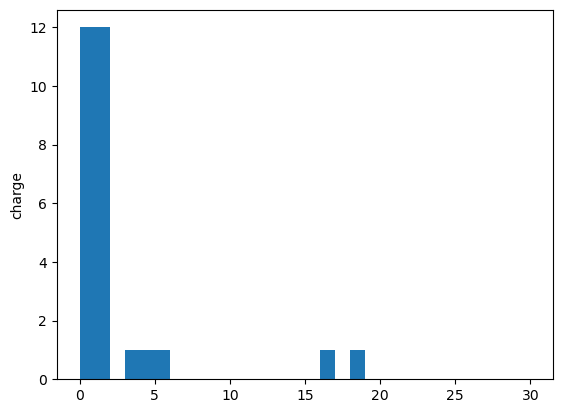

In [46]:
plt.hist(good_event_3_non_aux.charge, 30, (0, 30));
plt.ylabel("charge")

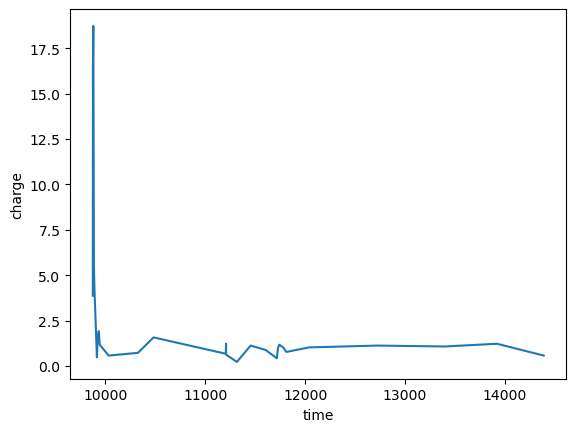

In [47]:
plt.plot(good_event_3_non_aux.time, good_event_3_non_aux.charge);
plt.xlabel('time')
plt.ylabel('charge');

It seems like our model gives better predictions on events with larger cumulative charge. To test this 
we would like to look at a scatter plot of cumulative charge of non-auxiliary events vs. angular error.

In [48]:
dg_part = get_IceCube_data_generator(valid_meta,
                                     valid_batch,
                                     counter_df,
                                     batch_size = 1024)
X_part, y_part = dg_part.__next__()
y_part_pred = model(X_part)

In [53]:
 X_part.shape, y_part.shape, y_part_pred.shape

((1024, 6000, 4), (1024, 2), TensorShape([1024, 2]))

In [55]:
beta = [angular_error(y_part[i], y_part_pred[i]) for i in range(1024)]
beta

[<tf.Tensor: shape=(), dtype=float64, numpy=1.3051783973020095>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4765809957307765>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.8276850927266455>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.680573558529852>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.202128866836364>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.0118112642536428>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.575477109646136>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.0518555395148383>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.3346609930275535>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.159869055943126>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.4456271658972217>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.0339194499134807>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.2410165983690353>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.7615571973843744>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.186857431357562>,
 <tf.Tensor: shape=(), dtype=f

In [64]:
alpha = (np.exp(10 * X_part[:,:, 3]) - 1).sum(axis=1)

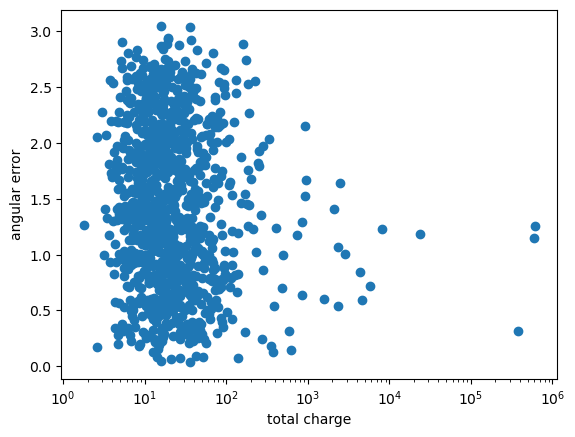

In [67]:
plt.scatter(alpha, beta)
plt.xlabel('total charge')
plt.ylabel('angular error')
plt.xscale('log')

The correlation between the quality of our prediction and the charge seems to be very slight. We don't predict opposite direction on events with charge more than 10e-3.

In [32]:
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)


We increase the complexity of our model to see if we can improve the performance.

 **Add a CONV layer**

In [36]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(16,10,strides=1,padding="same",activation="relu")(x)
x = Conv1D(16,10,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [37]:
model_2 = Model(i,x)
model_2.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [38]:
r = model_2.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 2153s 344ms/step - loss: 1.4907 - mean_angular_error: 1.4907 - val_loss: 1.4606 - val_mean_angular_error: 1.4606
Epoch 2/8
6251/6251 [==============================] - 2141s 343ms/step - loss: 1.4653 - mean_angular_error: 1.4653 - val_loss: 1.4520 - val_mean_angular_error: 1.4520
Epoch 3/8
6251/6251 [==============================] - 2160s 346ms/step - loss: 1.4564 - mean_angular_error: 1.4564 - val_loss: 1.4430 - val_mean_angular_error: 1.4430
Epoch 4/8
6251/6251 [==============================] - 2164s 346ms/step - loss: 1.4497 - mean_angular_error: 1.4497 - val_loss: 1.4363 - val_mean_angular_error: 1.4363
Epoch 5/8
6251/6251 [==============================] - 2147s 343ms/step - loss: 1.4419 - mean_angular_error: 1.4419 - val_loss: 1.4299 - val_mean_angular_error: 1.4299
Epoch 6/8
6251/6251 [==============================] - 2214s 354ms/step - loss: 1.4357 - mean_angular_error: 1.4357 - val_loss: 1.4167 - val_mean_angular_error:

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**Increase the number of filters in the second CONV layer**

In [11]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,10,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [12]:
model_3 = Model(i,x)
model_3.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [13]:
r = model_3.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 2076s 332ms/step - loss: 1.4849 - mean_angular_error: 1.4849 - val_loss: 1.4598 - val_mean_angular_error: 1.4598
Epoch 2/8
6251/6251 [==============================] - 2058s 329ms/step - loss: 1.4641 - mean_angular_error: 1.4641 - val_loss: 1.4537 - val_mean_angular_error: 1.4537
Epoch 3/8
6251/6251 [==============================] - 2079s 333ms/step - loss: 1.4568 - mean_angular_error: 1.4568 - val_loss: 1.4452 - val_mean_angular_error: 1.4452
Epoch 4/8
6251/6251 [==============================] - 2042s 327ms/step - loss: 1.4496 - mean_angular_error: 1.4496 - val_loss: 1.4375 - val_mean_angular_error: 1.4375
Epoch 5/8
6251/6251 [==============================] - 2034s 325ms/step - loss: 1.4447 - mean_angular_error: 1.4447 - val_loss: 1.4330 - val_mean_angular_error: 1.4330
Epoch 6/8
6251/6251 [==============================] - 2068s 331ms/step - loss: 1.4355 - mean_angular_error: 1.4355 - val_loss: 1.4192 - val_mean_angular_error:

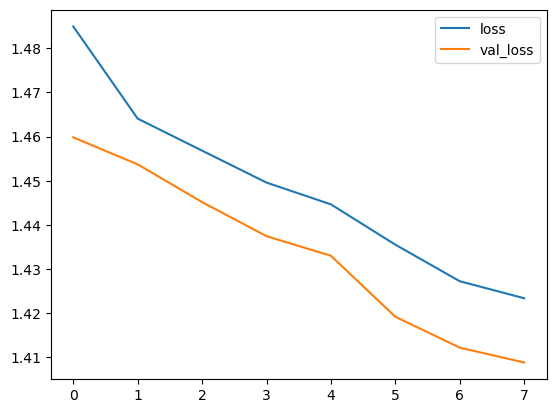

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**3 CONV layers each with double the number of filters of the previous layer, odd size filters, run for more epochs**

In [11]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,13,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [12]:
model_4 = Model(i,x)
model_4.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [13]:
r = model_4.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=15)

Epoch 1/15
6251/6251 [==============================] - 2307s 369ms/step - loss: 1.4880 - mean_angular_error: 1.4880 - val_loss: 1.4540 - val_mean_angular_error: 1.4540
Epoch 2/15
6251/6251 [==============================] - 2296s 367ms/step - loss: 1.4524 - mean_angular_error: 1.4524 - val_loss: 1.4382 - val_mean_angular_error: 1.4382
Epoch 3/15
6251/6251 [==============================] - 2304s 369ms/step - loss: 1.4431 - mean_angular_error: 1.4431 - val_loss: 1.4321 - val_mean_angular_error: 1.4321
Epoch 4/15
6251/6251 [==============================] - 2269s 363ms/step - loss: 1.4358 - mean_angular_error: 1.4358 - val_loss: 1.4273 - val_mean_angular_error: 1.4273
Epoch 5/15
6251/6251 [==============================] - 2264s 362ms/step - loss: 1.4304 - mean_angular_error: 1.4304 - val_loss: 1.4228 - val_mean_angular_error: 1.4228
Epoch 6/15
6251/6251 [==============================] - 2264s 362ms/step - loss: 1.4257 - mean_angular_error: 1.4257 - val_loss: 1.4184 - val_mean_angular_

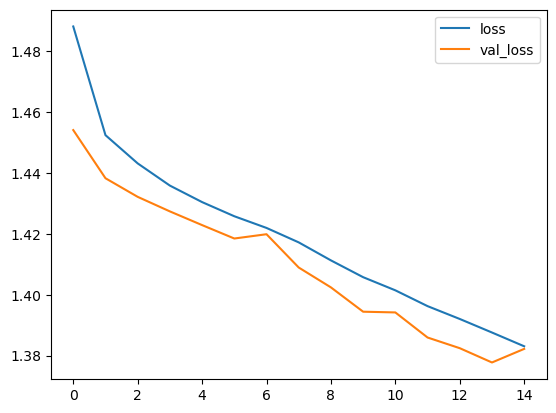

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [15]:
# save the model
model_4.save('cnn1d-fit-4.hd5')
os.chdir(r'/kaggle/working')
!tar czf cnn1d-fit-4.hd5.tgz cnn1d-fit-4.hd5/
FileLink('cnn1d-fit-4.hd5.tgz')

/kaggle/working/cnn1d-fit-4.hd5.tgz

In [18]:
shutil.copy('/kaggle/input/cnn1d-fit-4/cnn1d-fit-4.hd5.tgz', '/kaggle/working/')
os.listdir('/kaggle/working/')

['cnn1d-fit-4.hd5',
 '.virtual_documents',
 '__notebook_source__.ipynb',
 'cnn1d-fit-4.hd5.tgz']

In [19]:
!tar xzf cnn1d-fit-4.hd5.tgz

In [20]:
# load model 4
from tensorflow.keras.models import load_model
model_4 = load_model('/kaggle/working/cnn1d-fit-4.hd5',
                  custom_objects={"mean_angular_error": mean_angular_error})
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6000, 4)]         0         
                                                                 
 conv1d (Conv1D)             (None, 6000, 16)          336       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1500, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1500, 32)          5664      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 375, 64)           26688 

#### Plot the error vs the charge of the event for this model.

In [21]:
dg_part = get_IceCube_data_generator(valid_meta,
                                     valid_batch,
                                     counter_df,
                                     batch_size = 1024)
X_part, y_part = dg_part.__next__()
y_part_pred = model_4(X_part)

In [24]:
alpha = (np.exp(10 * X_part[:,:, 3]) - 1).sum(axis=1)
beta = [angular_error(y_part[i], y_part_pred[i]) for i in range(1024)]

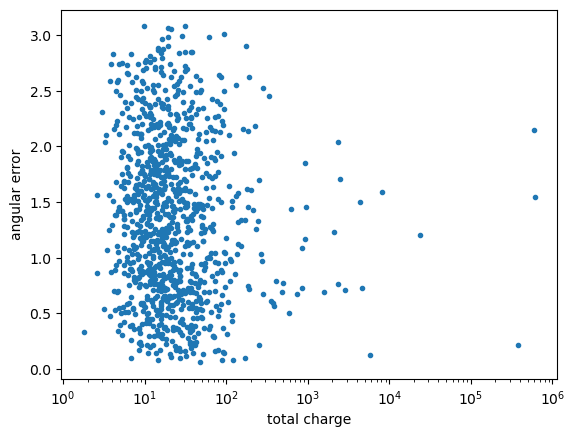

In [31]:
plt.scatter(alpha, beta, marker='.')
plt.xlabel('total charge')
plt.ylabel('angular error')
plt.xscale('log')

#### Plot predicted vs true zenith angles

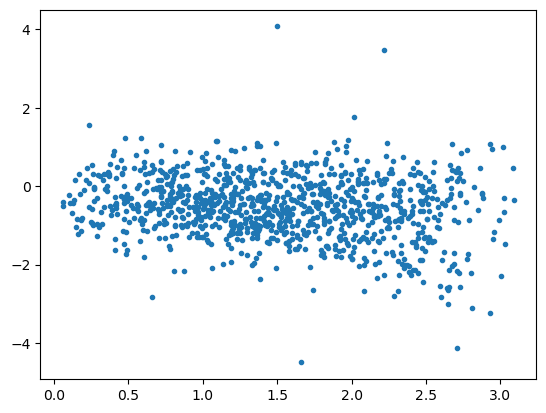

In [33]:
plt.scatter(y_part[:,1], y_part_pred[:,1], marker='.')

Seeing that sometimes we predict negative zenith angle while it should always be positive, we will try a different loss function.

#### Try a different loss fumction (ms_angular_error) while still tracking the previous measure (mean_angular_error).

In [11]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [12]:
model_5 = Model(i,x)
model_5.compile(loss=ms_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error, ms_angular_error])

In [13]:
r = model_5.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 2121s 339ms/step - loss: 2.2631 - mean_angular_error: 1.5296 - ms_angular_error: 2.2631 - val_loss: 2.3077 - val_mean_angular_error: 1.5248 - val_ms_angular_error: 2.3077
Epoch 2/8
6251/6251 [==============================] - 2152s 344ms/step - loss: 2.2488 - mean_angular_error: 1.5219 - ms_angular_error: 2.2488 - val_loss: 2.2894 - val_mean_angular_error: 1.5216 - val_ms_angular_error: 2.2894
Epoch 3/8
6251/6251 [==============================] - 2161s 346ms/step - loss: 2.2458 - mean_angular_error: 1.5195 - ms_angular_error: 2.2458 - val_loss: 2.2751 - val_mean_angular_error: 1.5204 - val_ms_angular_error: 2.2751
Epoch 4/8
6251/6251 [==============================] - 2103s 336ms/step - loss: 2.2438 - mean_angular_error: 1.5179 - ms_angular_error: 2.2438 - val_loss: 2.2698 - val_mean_angular_error: 1.5177 - val_ms_angular_error: 2.2698
Epoch 5/8
6251/6251 [==============================] - 2091s 334ms/step - loss: 2.2426 - mean_an

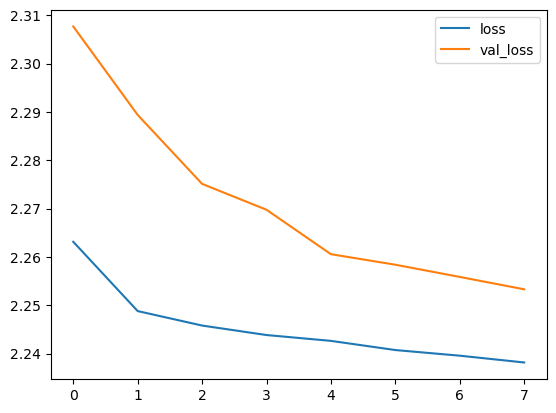

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

The new loss function is not successfull

#### Proceed adding convolutional layers

#### model with 4 conv layers

In [15]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(24,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [16]:
model_6 = Model(i,x)
model_6.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error, ms_angular_error])

In [17]:
r = model_6.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1745s 279ms/step - loss: 1.4927 - mean_angular_error: 1.4927 - ms_angular_error: 8.9610 - val_loss: 1.4489 - val_mean_angular_error: 1.4489 - val_ms_angular_error: 10.9424
Epoch 2/8
6251/6251 [==============================] - 1759s 281ms/step - loss: 1.4426 - mean_angular_error: 1.4426 - ms_angular_error: 12.4525 - val_loss: 1.4274 - val_mean_angular_error: 1.4274 - val_ms_angular_error: 11.2149
Epoch 3/8
6251/6251 [==============================] - 1823s 292ms/step - loss: 1.4258 - mean_angular_error: 1.4258 - ms_angular_error: 12.2440 - val_loss: 1.4092 - val_mean_angular_error: 1.4092 - val_ms_angular_error: 11.5084
Epoch 4/8
6251/6251 [==============================] - 1772s 283ms/step - loss: 1.4154 - mean_angular_error: 1.4154 - ms_angular_error: 12.3356 - val_loss: 1.4035 - val_mean_angular_error: 1.4035 - val_ms_angular_error: 11.3739
Epoch 5/8
6251/6251 [==============================] - 1760s 282ms/step - loss: 1.4081 - 

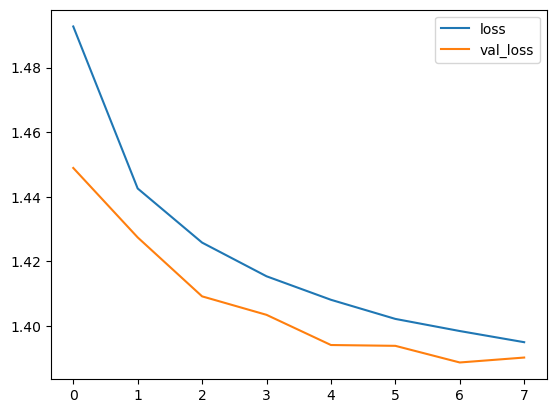

In [18]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [16]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(24,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(48,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [17]:
model_7 = Model(i,x)
model_7.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [18]:
r = model_7.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1749s 280ms/step - loss: 1.4964 - mean_angular_error: 1.4964 - val_loss: 1.4615 - val_mean_angular_error: 1.4615
Epoch 2/8
6251/6251 [==============================] - 1771s 283ms/step - loss: 1.4540 - mean_angular_error: 1.4540 - val_loss: 1.4388 - val_mean_angular_error: 1.4388
Epoch 3/8
6251/6251 [==============================] - 1771s 283ms/step - loss: 1.4344 - mean_angular_error: 1.4344 - val_loss: 1.4210 - val_mean_angular_error: 1.4210
Epoch 4/8
6251/6251 [==============================] - 1734s 277ms/step - loss: 1.4218 - mean_angular_error: 1.4218 - val_loss: 1.4137 - val_mean_angular_error: 1.4137
Epoch 5/8
6251/6251 [==============================] - 1733s 277ms/step - loss: 1.4129 - mean_angular_error: 1.4129 - val_loss: 1.3998 - val_mean_angular_error: 1.3998
Epoch 6/8
6251/6251 [==============================] - 1722s 276ms/step - loss: 1.4075 - mean_angular_error: 1.4075 - val_loss: 1.3976 - val_mean_angular_error:

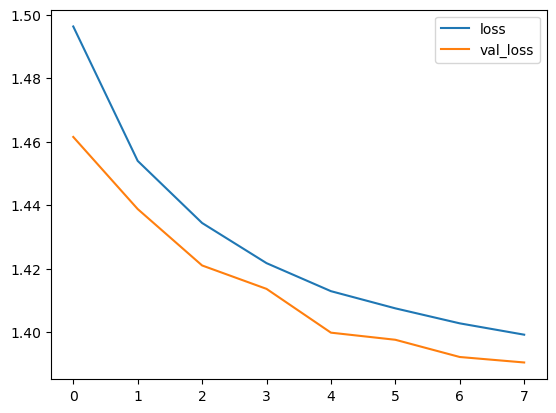

In [19]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

#### model with 5 conv layers

In [20]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(24,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(48,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,13,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [21]:
model_8 = Model(i,x)
model_8.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [22]:
r = model_8.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1754s 280ms/step - loss: 1.5128 - mean_angular_error: 1.5128 - val_loss: 1.4618 - val_mean_angular_error: 1.4618
Epoch 2/8
6251/6251 [==============================] - 1743s 279ms/step - loss: 1.4417 - mean_angular_error: 1.4417 - val_loss: 1.4155 - val_mean_angular_error: 1.4155
Epoch 3/8
6251/6251 [==============================] - 1745s 279ms/step - loss: 1.4079 - mean_angular_error: 1.4079 - val_loss: 1.3913 - val_mean_angular_error: 1.3913
Epoch 4/8
6251/6251 [==============================] - 1893s 303ms/step - loss: 1.3898 - mean_angular_error: 1.3898 - val_loss: 1.3749 - val_mean_angular_error: 1.3749
Epoch 5/8
6251/6251 [==============================] - 1898s 304ms/step - loss: 1.3786 - mean_angular_error: 1.3786 - val_loss: 1.3666 - val_mean_angular_error: 1.3666
Epoch 6/8
6251/6251 [==============================] - 1889s 302ms/step - loss: 1.3705 - mean_angular_error: 1.3705 - val_loss: 1.3596 - val_mean_angular_error:

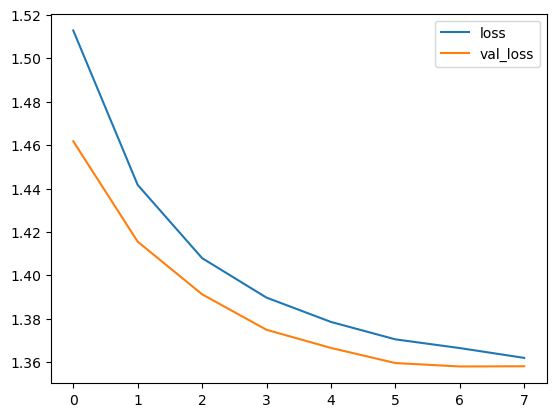

In [23]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**More traditional model with all filters of the same size**

In [10]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,5,strides=1,padding="same",activation="relu")(x)
x = Conv1D(32,5,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,5,strides=1,padding="same",activation="relu")(x)
x = Conv1D(64,5,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [11]:
model_9 = Model(i,x)
model_9.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [12]:
r = model_9.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 2591s 414ms/step - loss: 1.4978 - mean_angular_error: 1.4978 - val_loss: 1.4605 - val_mean_angular_error: 1.4605
Epoch 2/8
6251/6251 [==============================] - 2558s 409ms/step - loss: 1.4599 - mean_angular_error: 1.4599 - val_loss: 1.4462 - val_mean_angular_error: 1.4462
Epoch 3/8
6251/6251 [==============================] - 2518s 403ms/step - loss: 1.4484 - mean_angular_error: 1.4484 - val_loss: 1.4388 - val_mean_angular_error: 1.4388
Epoch 4/8
6251/6251 [==============================] - 2510s 402ms/step - loss: 1.4390 - mean_angular_error: 1.4390 - val_loss: 1.4261 - val_mean_angular_error: 1.4261
Epoch 5/8
6251/6251 [==============================] - 2502s 400ms/step - loss: 1.4275 - mean_angular_error: 1.4275 - val_loss: 1.4134 - val_mean_angular_error: 1.4134
Epoch 6/8
6251/6251 [==============================] - 2497s 399ms/step - loss: 1.4192 - mean_angular_error: 1.4192 - val_loss: 1.4014 - val_mean_angular_error:

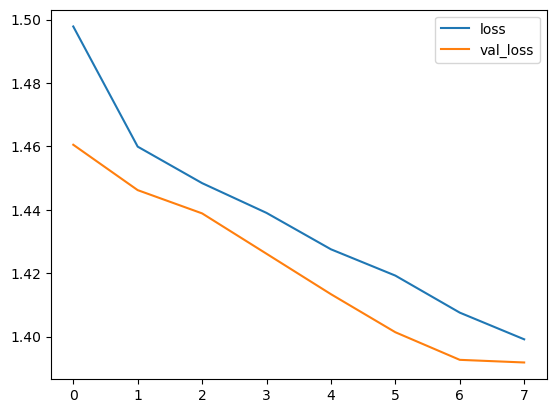

In [13]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

Having pairs of consecutive convolutional layers in a model does not seem to give best results.

**Model 8 gave the best result so far. Lets try some variations of it.**

1. Making the size of filters slightly smaller and pool_size of the first pooling layer smaller does not improve the outcome, but makes the model to run slower.

### models with 6 conv layers

**Model 10 is a variation of model 8: number of filters is a power of 2**

In [16]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(128,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [17]:
model_10 = Model(i,x)
model_10.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [18]:
r = model_10.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1921s 307ms/step - loss: 1.5341 - mean_angular_error: 1.5341 - val_loss: 1.4964 - val_mean_angular_error: 1.4964
Epoch 2/8
6251/6251 [==============================] - 1877s 300ms/step - loss: 1.4544 - mean_angular_error: 1.4544 - val_loss: 1.4410 - val_mean_angular_error: 1.4410
Epoch 3/8
6251/6251 [==============================] - 1867s 299ms/step - loss: 1.4041 - mean_angular_error: 1.4041 - val_loss: 1.3977 - val_mean_angular_error: 1.3977
Epoch 4/8
6251/6251 [==============================] - 1877s 300ms/step - loss: 1.3819 - mean_angular_error: 1.3819 - val_loss: 1.3776 - val_mean_angular_error: 1.3776
Epoch 5/8
6251/6251 [==============================] - 1945s 311ms/step - loss: 1.3708 - mean_angular_error: 1.3708 - val_loss: 1.3612 - val_mean_angular_error: 1.3612
Epoch 6/8
6251/6251 [==============================] - 1918s 307ms/step - loss: 1.3633 - mean_angular_error: 1.3633 - val_loss: 1.3682 - val_mean_angular_error:

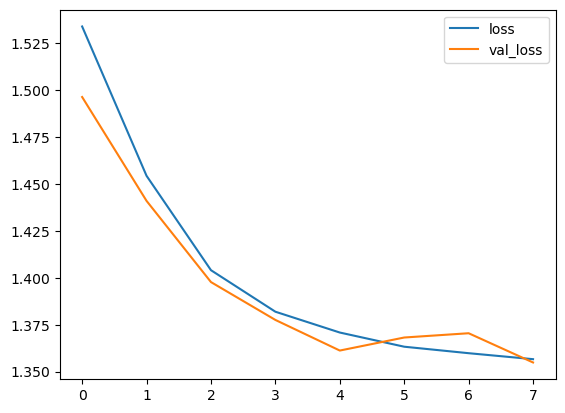

In [19]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [24]:
# save the model
model_10.save('cnn1d-fit-10.hd5')
os.chdir(r'/kaggle/working')
!tar czf cnn1d-fit-10.hd5.tgz cnn1d-fit-10.hd5/
FileLink('cnn1d-fit-10.hd5.tgz')

/kaggle/working/cnn1d-fit-10.hd5.tgz

In [21]:
dg_part = get_IceCube_data_generator(valid_meta,
                                     valid_batch,
                                     counter_df,
                                     batch_size = 1024)
X_part, y_part = dg_part.__next__()
y_part_pred = model_10(X_part)

In [22]:
alpha = (np.exp(10 * X_part[:,:, 3]) - 1).sum(axis=1)
beta = [angular_error(y_part[i], y_part_pred[i]) for i in range(1024)]

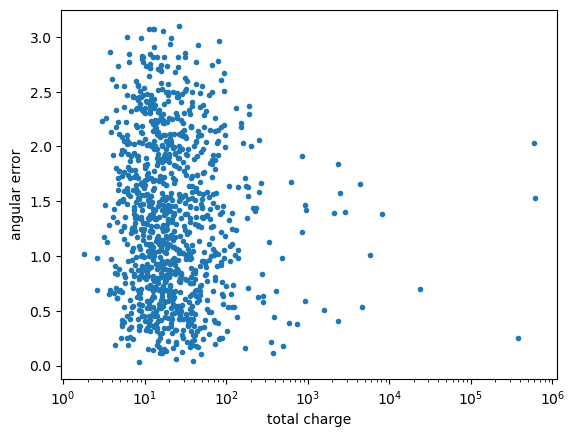

In [23]:
plt.scatter(alpha, beta, marker='.')
plt.xlabel('total charge')
plt.ylabel('angular error')
plt.xscale('log')

We investigate the effect of switching the Dropout and Dense layers on a smaller model 7.

**We tried a model that is the same as model 7, but with Dropout and Dense layers switched**

The loss function became NaN in the 2nd epoch. We then tried to half the number of nodes in the dense layer. In this case it took 4 epochs for the loss function to become NaN.

Last try to switch Dropout and Dense layers in model 7. This time we added another dense layer.

In [10]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(24,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(48,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [11]:
model_12 = Model(i,x)
model_12.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [12]:
r = model_12.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1754s 280ms/step - loss: 1.4887 - mean_angular_error: 1.4887 - val_loss: 1.4396 - val_mean_angular_error: 1.4396
Epoch 2/8
6251/6251 [==============================] - 1741s 279ms/step - loss: 1.4264 - mean_angular_error: 1.4264 - val_loss: 1.4134 - val_mean_angular_error: 1.4134
Epoch 3/8
6251/6251 [==============================] - 1757s 281ms/step - loss: 1.4076 - mean_angular_error: 1.4076 - val_loss: 1.4028 - val_mean_angular_error: 1.4028
Epoch 4/8
6251/6251 [==============================] - 1782s 285ms/step - loss: 1.3945 - mean_angular_error: 1.3945 - val_loss: 1.3952 - val_mean_angular_error: 1.3952
Epoch 5/8
6251/6251 [==============================] - 1780s 285ms/step - loss: 1.3849 - mean_angular_error: 1.3849 - val_loss: 1.3832 - val_mean_angular_error: 1.3832
Epoch 6/8
6251/6251 [==============================] - 1847s 296ms/step - loss: 1.3789 - mean_angular_error: 1.3789 - val_loss: 1.3812 - val_mean_angular_error:

In [13]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss'
plt.legend()

SyntaxError: invalid syntax (3687323657.py, line 3)

**We next try model 10 with a little smaller dropout, hoping to improve performance without overfitting.**

In [16]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(128,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(512)(x)
x = Dense(2)(x)

In [17]:
model_11 = Model(i,x)
model_11.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [18]:
r = model_11.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1785s 285ms/step - loss: 1.5244 - mean_angular_error: 1.5244 - val_loss: 1.4834 - val_mean_angular_error: 1.4834
Epoch 2/8
6251/6251 [==============================] - 1790s 286ms/step - loss: 1.4358 - mean_angular_error: 1.4358 - val_loss: 1.4294 - val_mean_angular_error: 1.4294
Epoch 3/8
6251/6251 [==============================] - 1791s 287ms/step - loss: 1.3983 - mean_angular_error: 1.3983 - val_loss: 1.3856 - val_mean_angular_error: 1.3856
Epoch 4/8
6251/6251 [==============================] - 1793s 287ms/step - loss: 1.3825 - mean_angular_error: 1.3825 - val_loss: 1.3751 - val_mean_angular_error: 1.3751
Epoch 5/8
6251/6251 [==============================] - 1783s 285ms/step - loss: 1.3759 - mean_angular_error: 1.3759 - val_loss: 1.3744 - val_mean_angular_error: 1.3744
Epoch 6/8
6251/6251 [==============================] - 1774s 284ms/step - loss: 1.3688 - mean_angular_error: 1.3688 - val_loss: 1.3699 - val_mean_angular_error:

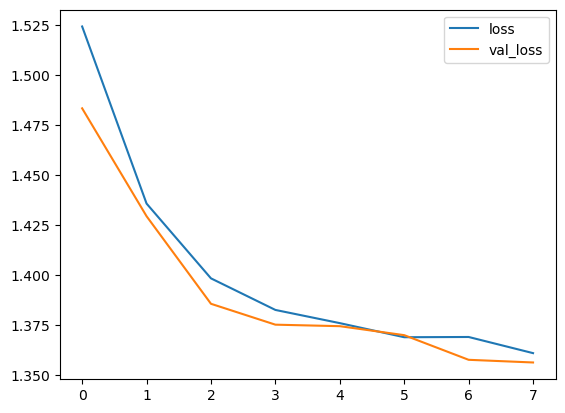

In [19]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**Will try model 10 with Dropout between two Dense layers at the end**

In [13]:
np.random.seed(2345)
tf.random.set_seed(2345)

In [17]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(128,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [18]:
model_13 = Model(i,x)
model_13.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [19]:
r = model_13.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1816s 290ms/step - loss: 1.5351 - mean_angular_error: 1.5351 - val_loss: 1.5138 - val_mean_angular_error: 1.5138
Epoch 2/8
6251/6251 [==============================] - 1801s 288ms/step - loss: 1.4529 - mean_angular_error: 1.4529 - val_loss: 1.4471 - val_mean_angular_error: 1.4471
Epoch 3/8
6251/6251 [==============================] - 1763s 282ms/step - loss: 1.4030 - mean_angular_error: 1.4030 - val_loss: 1.4084 - val_mean_angular_error: 1.4084
Epoch 4/8
6251/6251 [==============================] - 1754s 281ms/step - loss: 1.3803 - mean_angular_error: 1.3803 - val_loss: 1.3847 - val_mean_angular_error: 1.3847
Epoch 5/8
6251/6251 [==============================] - 1781s 285ms/step - loss: 1.3680 - mean_angular_error: 1.3680 - val_loss: 1.3731 - val_mean_angular_error: 1.3731
Epoch 6/8
6251/6251 [==============================] - 1772s 284ms/step - loss: 1.3606 - mean_angular_error: 1.3606 - val_loss: 1.3546 - val_mean_angular_error:

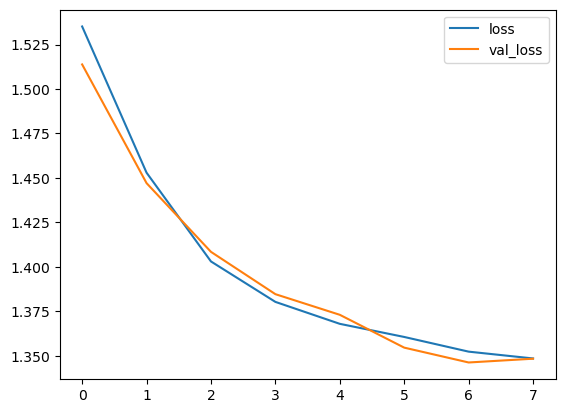

In [20]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

#### 7 conv layers

With 7 conv layers we cannot max_pool each time with pool_size = 4 (6000 /4 ** 7 < 1). We need to consider other architectures.

**Computations for model 14**

Start with T=6000
1. 1st Conv layer and MaxPool: pool_size=4, T=1500
2. 2nd Conv layer and MaxPool: pool_size=4, T=375
3. 3rd Conv layer and MaxPool: pool_size=2, T=188
4. 4th Conv layer and MaxPool: pool_size=2, T=94
5. 5th Conv layer and MaxPool: pool_size=2, T=47
6. 6th Conv layer and MaxPool: pool_size=2, T=25
7. 7th Conv layer and MaxPool: pool_size=4, T=7

In [22]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,7, strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [23]:
model_14 = Model(i,x)
model_14.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [24]:
r = model_14.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1946s 311ms/step - loss: 1.5203 - mean_angular_error: 1.5203 - val_loss: 1.4714 - val_mean_angular_error: 1.4714
Epoch 2/8
6251/6251 [==============================] - 1939s 310ms/step - loss: 1.4326 - mean_angular_error: 1.4326 - val_loss: 1.4179 - val_mean_angular_error: 1.4179
Epoch 3/8
6251/6251 [==============================] - 1935s 310ms/step - loss: 1.3964 - mean_angular_error: 1.3964 - val_loss: 1.3912 - val_mean_angular_error: 1.3912
Epoch 4/8
6251/6251 [==============================] - 1928s 308ms/step - loss: 1.3781 - mean_angular_error: 1.3781 - val_loss: 1.3859 - val_mean_angular_error: 1.3859
Epoch 5/8
6251/6251 [==============================] - 1918s 307ms/step - loss: 1.3730 - mean_angular_error: 1.3730 - val_loss: 1.3723 - val_mean_angular_error: 1.3723
Epoch 6/8
6251/6251 [==============================] - 1922s 307ms/step - loss: 1.3583 - mean_angular_error: 1.3583 - val_loss: 1.3640 - val_mean_angular_error:

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**Computations for model 15**
1. We start with T = 6000
2. After 1st Conv layer, padding is the same so T=6000
3. After MaxPool with pool_size=4 T=ceil((6000 - 4)/4) + 1 = 1500
4. 2nd Conv and MaxPool: pool_size = 4, T=375
5. 3rd Conv and MaxPool: pool_size=4 T=94
6. 4th Conv and MaxPool: pool_size=4, T=24
7. 5th Conv and MaxPool: pool_size=2, T=12
8. 6th Conv and MaxPool: pool_size=2, T=6

In [11]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7, strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(64,5,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,3,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128,3,strides=1,padding="same",activation="relu")(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [12]:
model_15 = Model(i,x)
model_15.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [13]:
r = model_15.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1813s 290ms/step - loss: 1.5361 - mean_angular_error: 1.5361 - val_loss: 1.5335 - val_mean_angular_error: 1.5335
Epoch 2/8
6251/6251 [==============================] - 1775s 284ms/step - loss: 1.4777 - mean_angular_error: 1.4777 - val_loss: 1.4284 - val_mean_angular_error: 1.4284
Epoch 3/8
6251/6251 [==============================] - 1762s 282ms/step - loss: 1.4122 - mean_angular_error: 1.4122 - val_loss: 1.3971 - val_mean_angular_error: 1.3971
Epoch 4/8
6251/6251 [==============================] - 1757s 281ms/step - loss: 1.3876 - mean_angular_error: 1.3876 - val_loss: 1.3897 - val_mean_angular_error: 1.3897
Epoch 5/8
6251/6251 [==============================] - 1756s 281ms/step - loss: 1.3794 - mean_angular_error: 1.3794 - val_loss: 1.3845 - val_mean_angular_error: 1.3845
Epoch 6/8
6251/6251 [==============================] - 1754s 281ms/step - loss: 1.3649 - mean_angular_error: 1.3649 - val_loss: 1.3843 - val_mean_angular_error:

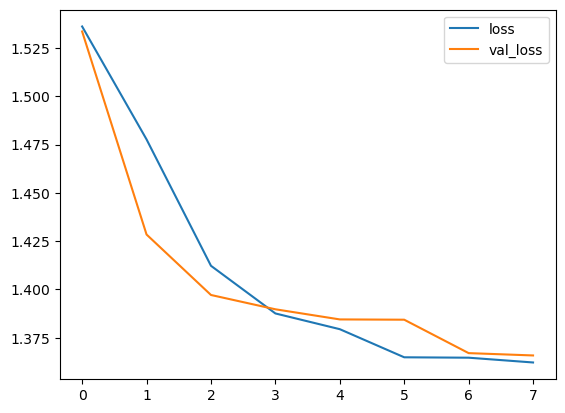

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

**Calculations for model 16**
Start with T=6000
1. 1st Conv layer and MaxPool: pool_size=4, T=1500
2. 2nd Conv layer and MaxPool: pool_size=4, T=375
3. 3rd Conv layer and MaxPool: pool_size=4, T=94
4. 4th Conv layer and MaxPool: pool_size=2, T=47
5. 5th Conv layer and MaxPool: pool_size=2, T=24
6. 6th Conv layer and MaxPool: pool_size=2, T=12
7. 7th Conv layer and MaxPool: pool_size=2, T=6


In [11]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7, strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [12]:
model_16 = Model(i,x)
model_16.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [13]:
r = model_16.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=8)

Epoch 1/8
6251/6251 [==============================] - 1861s 297ms/step - loss: 1.5236 - mean_angular_error: 1.5236 - val_loss: 1.4813 - val_mean_angular_error: 1.4813
Epoch 2/8
6251/6251 [==============================] - 1851s 296ms/step - loss: 1.4402 - mean_angular_error: 1.4402 - val_loss: 1.4419 - val_mean_angular_error: 1.4419
Epoch 3/8
6251/6251 [==============================] - 1801s 288ms/step - loss: 1.3949 - mean_angular_error: 1.3949 - val_loss: 1.3880 - val_mean_angular_error: 1.3880
Epoch 4/8
6251/6251 [==============================] - 1814s 290ms/step - loss: 1.3750 - mean_angular_error: 1.3750 - val_loss: 1.3831 - val_mean_angular_error: 1.3831
Epoch 5/8
6251/6251 [==============================] - 1789s 286ms/step - loss: 1.3660 - mean_angular_error: 1.3660 - val_loss: 1.3779 - val_mean_angular_error: 1.3779
Epoch 6/8
6251/6251 [==============================] - 1809s 289ms/step - loss: 1.3580 - mean_angular_error: 1.3580 - val_loss: 1.3607 - val_mean_angular_error:

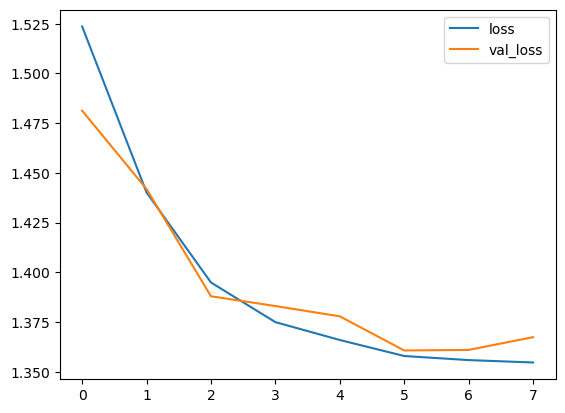

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

Model 16 seems to overfit slightly. We reduced second to last Dense layer from 512 to 256 nodes, but that gave loss NaN in the 8 epoch.

Model 14 seems to be our best model. We will run model 14 for 15 epochs.

In [14]:
T = 6000
D = 4
B = 64
i = Input(shape=(T,D))
x = Conv1D(16,5,strides=1,padding="same",activation="relu")(i)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Conv1D(32,7,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,7, strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,9,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128,11,strides=1,padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = Dense(2)(x)

In [15]:
model_14 = Model(i,x)
model_14.compile(loss=mean_angular_error,
              optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8),
              metrics=[mean_angular_error])

In [16]:
r = model_14.fit(get_IceCube_data_generator(train_meta,train_batch,counter_df,batch_size=B),
              steps_per_epoch=train_meta.shape[0]//B+1,
              validation_data=get_IceCube_data_generator(valid_meta,valid_batch,counter_df,batch_size=B),
              validation_steps=valid_meta.shape[0]//B+1,
              batch_size=B, validation_batch_size=B, epochs=15)

Epoch 1/15
6251/6251 [==============================] - 1829s 292ms/step - loss: 1.5318 - mean_angular_error: 1.5318 - val_loss: 1.4945 - val_mean_angular_error: 1.4945
Epoch 2/15
6251/6251 [==============================] - 1839s 294ms/step - loss: 1.4503 - mean_angular_error: 1.4503 - val_loss: 1.4253 - val_mean_angular_error: 1.4253
Epoch 3/15
6251/6251 [==============================] - 1828s 293ms/step - loss: 1.4024 - mean_angular_error: 1.4024 - val_loss: 1.3983 - val_mean_angular_error: 1.3983
Epoch 4/15
6251/6251 [==============================] - 1831s 293ms/step - loss: 1.3785 - mean_angular_error: 1.3785 - val_loss: 1.3696 - val_mean_angular_error: 1.3696
Epoch 5/15
6251/6251 [==============================] - 1825s 292ms/step - loss: 1.3667 - mean_angular_error: 1.3667 - val_loss: 1.3580 - val_mean_angular_error: 1.3580
Epoch 6/15
6251/6251 [==============================] - 1816s 290ms/step - loss: 1.3629 - mean_angular_error: 1.3629 - val_loss: 1.3609 - val_mean_angular_

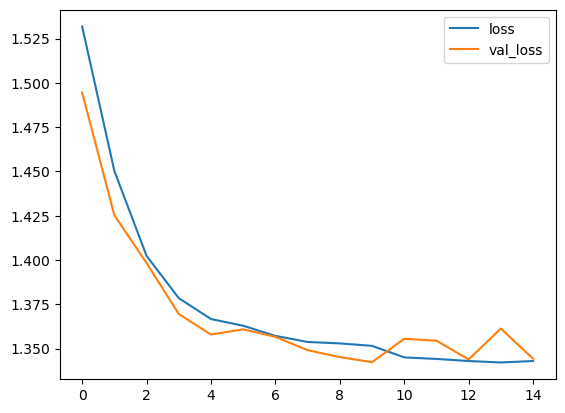

In [17]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [18]:
# save the model
model_14.save('cnn1d-fit-14.hd5')
os.chdir(r'/kaggle/working')
!tar czf cnn1d-fit-14.hd5.tgz cnn1d-fit-14.hd5/
FileLink('cnn1d-fit-14.hd5.tgz')

/kaggle/working/cnn1d-fit-14.hd5.tgz

In [15]:
shutil.copy('/kaggle/input/cnn1d-fit-14/cnn1d-fit-14.hd5.tgz', '/kaggle/working/')

'/kaggle/working/cnn1d-fit-14.hd5.tgz'

In [17]:
!tar xzf cnn1d-fit-14.hd5.tgz

In [19]:
from tensorflow.keras.models import load_model
final_model = load_model('/kaggle/working/cnn1d-fit-14.hd5',
                  custom_objects={"mean_angular_error": mean_angular_error})
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6000, 4)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 6000, 16)          336       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1500, 16)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 1500, 32)          3616      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 375, 32)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 375, 32)           7200

In [20]:
dg_part = get_IceCube_data_generator(valid_meta,
                                     valid_batch,
                                     counter_df,
                                     batch_size = 1024)
X_part, y_part = dg_part.__next__()
y_part_pred = final_model(X_part)

In [31]:
alpha = (np.exp(10 * X_part[:,:, 3]) - 1).sum(axis=1)
beta = np.array([angular_error(y_part[i], y_part_pred[i]) for i in range(1024)])

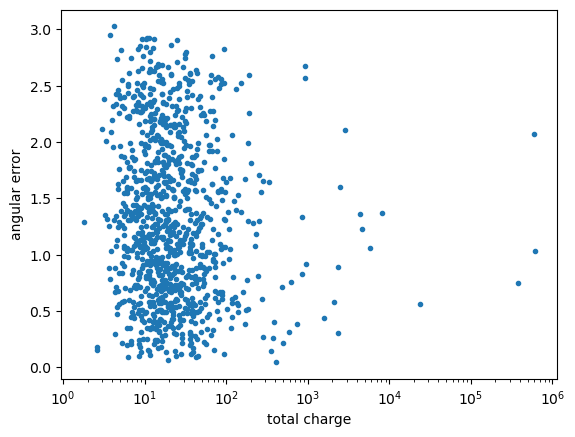

In [32]:
plt.scatter(alpha, beta, marker='.')
plt.xlabel('total charge')
plt.ylabel('angular error')
plt.xscale('log')

#### We plot mean angular error vs charge with its mean and standard deviation.

In [40]:
bin_edges = np.array([1.e0, 1.e1, 3.e1, 1.e2, 1.e3, 1.e4, 1.e6])
s0,_=np.histogram(alpha, bins=bin_edges)
s1,_ = np.histogram(alpha, bins=bin_edges, weights=beta)
s2,_ = np.histogram(alpha, bins=bin_edges, weights=beta * beta)
mean = s1 / s0
std = np.sqrt(s2/s0 - mean * mean)
bin_centers = np.sqrt(bin_edges[1:] * bin_edges[:-1])

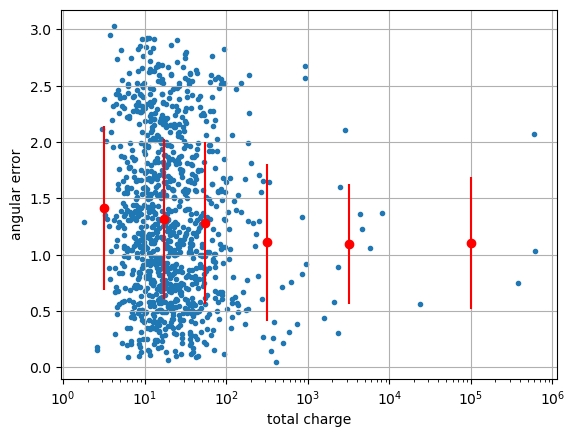

In [41]:
plt.scatter(alpha, beta, marker='.')
plt.errorbar(bin_centers, mean, yerr=std, fmt='ro')
plt.grid()
plt.xlabel('total charge')
plt.ylabel('angular error')
plt.xscale('log')